In [1]:
import importlib
# If available, will apply style to the plots using jupyterthemes
is_jupthemes_available = importlib.util.find_spec("jupyterthemes") is not None
# Call this function after '%matplotlib inline'
def plot_styling():
    if importlib.util.find_spec("jupyterthemes") is not None:
        from jupyterthemes import jtplot
        jtplot.style(figsize=(15, 8))
 # Just to show if we actually imported the module
print(is_jupthemes_available)

True


### 1. IsolationForest: Anomaly detection visualization

Generate sample distribution

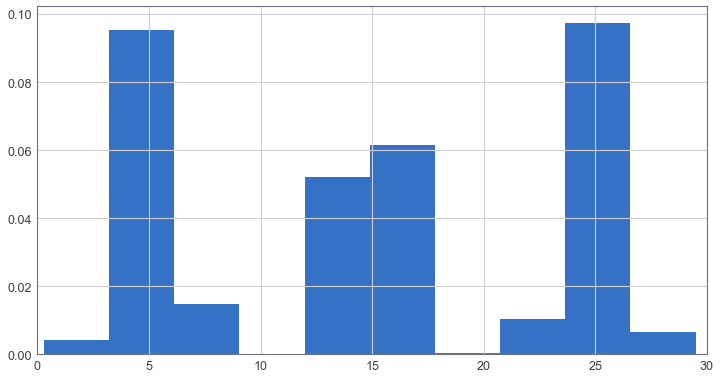

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
%matplotlib inline
plot_styling()
X = np.concatenate((
    np.random.normal(5, 1, 100000),
    np.random.normal(15, 1, 100000),
    np.random.normal(25, 1, 100000)
    )).reshape(-1, 1)
print()
plt.hist(X, density=True)
plt.xlim([0, 30])
plt.show()

Plot Outlier using fill_between

In [3]:
X.shape

(300000, 1)

166 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


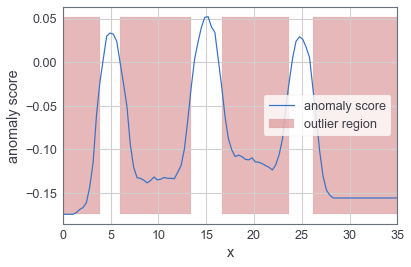

In [4]:
xx = np.linspace(0, 35, 100).reshape(-1,1)
# Train anomaly detection model
model = IsolationForest(random_state=1, n_jobs=-1, behaviour="new", contamination="auto")
%timeit model.fit(X)
anomaly_score = model.decision_function(xx)
outlier = model.predict(xx)
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('x')
plt.xlim([0, 35])
plt.show()


### 2. Seaborn legends

In [5]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg' 

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'
plot_styling()
import pandas as pd
import numpy as np

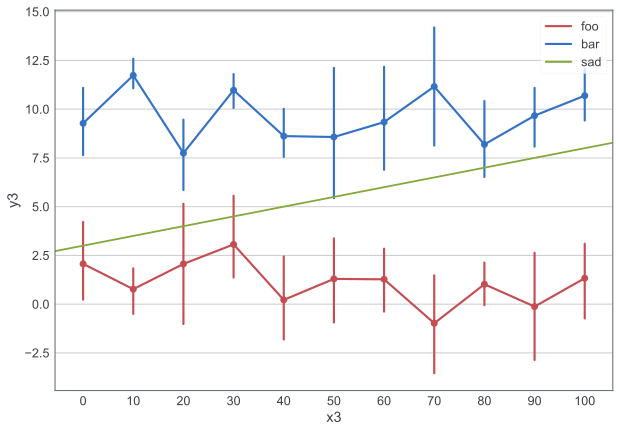

In [6]:
df1 = pd.DataFrame({
    "x1": np.repeat(np.arange(0, 101, 10), 5),
    "y1": np.random.normal(size=(55))*3 + 1
})


df2 = pd.DataFrame({
    "x2": np.repeat(np.arange(0, 101, 10), 5),
    "y2": np.random.normal(size=(55))*3 + 10
})

df3 = pd.DataFrame({
    "x3": np.arange(0, 10),
    "y3": 3 + np.arange(0, 10)*1/2
})

fig, ax = plt.subplots(figsize=(10, 7))
sns.pointplot(x="x1", y="y1", data=df1, marker="o", color="r", ax=ax)
sns.pointplot(x="x2", y="y2", data=df2, marker="o", color="b", ax=ax)
sns.regplot(x="x3", y="y3", data=df3, marker="", color="g", ax=ax)

# Add legends
ax.legend(labels=['foo', 'bar', 'sad'], loc=1)
leg = ax.get_legend()
leg.legendHandles[0].set_color('r')
leg.legendHandles[1].set_color('b')
leg.legendHandles[2].set_color('g')


### 3. A single pointplot in `plotly_express` calculating confidence interval using bootstrap

In [79]:
import plotly_express as px
from multiprocessing import Process, Manager

def px_pointlot(data, x=None, y=None, n_boot=1000, ci=95, **kwargs):
    print(kwargs)
    def f(d, n_boot, ci, key, val):
        p = 50 - ci / 2, 50 + ci / 2
        boot = np.sort([np.mean(np.random.choice(val, size=len(val))) for _ in range(n_boot)])
        b_mean = boot.mean()
        ci_vals = np.percentile(boot, p)
        err_min = abs(b_mean - ci_vals[0])
        err_max = abs(b_mean - ci_vals[1])
        d[key] = (b_mean, err_min, err_max)

    manager = Manager()
    my_dict = {k: data.iloc[val, :][y].values for k,val in data.groupby([x]).groups.items()}
    d = manager.dict()
    job = [Process(target=f, args=(d, n_boot, ci, k, v)) for k, v in my_dict.items()]
    _ = [p.start() for p in job]
    _ = [p.join() for p in job]
    sort_keys = sorted(d.keys())
    new_df  = pd.DataFrame({x: sort_keys,
                            y: [d[key][0] for key in sort_keys],
                            "err_min": [d[key][1] for key in sort_keys],
                            "err_max": [d[key][2] for key in sort_keys]})
    return px.line(new_df, x=x, y=y, error_y="err_max", error_y_minus="err_min", **kwargs)

px_pointlot(df_ci, x="x", y="y", color_discrete_sequence=["magenta"])

{'color_discrete_sequence': ['magenta']}
